In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

C:\Users\john\AppData\Local\Temp\ipykernel_32544\790046267.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(X), torch.tensor(y)
C:\Users\john\AppData\Local\Temp\ipykernel_32544\790046267.py:67: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))
C:\Users\john\AppData\Local\Temp\ipykernel_32544\790046267.py:69: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred, y_test))


Epoch 0: train RMSE 225.7929, test RMSE 425.0377
Epoch 100: train RMSE 182.5249, test RMSE 379.7154
Epoch 200: train RMSE 148.3833, test RMSE 342.6959
Epoch 300: train RMSE 118.3588, test RMSE 307.9193
Epoch 400: train RMSE 95.3181, test RMSE 277.5366
Epoch 500: train RMSE 72.8713, test RMSE 244.6812
Epoch 600: train RMSE 56.4414, test RMSE 214.6680
Epoch 700: train RMSE 45.0421, test RMSE 189.7571
Epoch 800: train RMSE 37.3220, test RMSE 168.2087
Epoch 900: train RMSE 31.8489, test RMSE 149.7472
Epoch 1000: train RMSE 28.0977, test RMSE 133.9482
Epoch 1100: train RMSE 25.4680, test RMSE 121.2543
Epoch 1200: train RMSE 23.7186, test RMSE 110.5219
Epoch 1300: train RMSE 22.6855, test RMSE 102.5538
Epoch 1400: train RMSE 21.9124, test RMSE 96.2818
Epoch 1500: train RMSE 21.4973, test RMSE 91.5695
Epoch 1600: train RMSE 21.0171, test RMSE 87.9781
Epoch 1700: train RMSE 20.5094, test RMSE 84.7849
Epoch 1800: train RMSE 20.4363, test RMSE 82.5246
Epoch 1900: train RMSE 19.8584, test RMSE 80

C:\Users\john\AppData\Local\Temp\ipykernel_32544\790046267.py:77: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  train_plot[lookback:train_size] = model(X_train)[:, -1, :]
C:\Users\john\AppData\Local\Temp\ipykernel_32544\790046267.py:80: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  test_plot[train_size + lookback : len(timeseries)] = model(X_test)[:, -1, :]


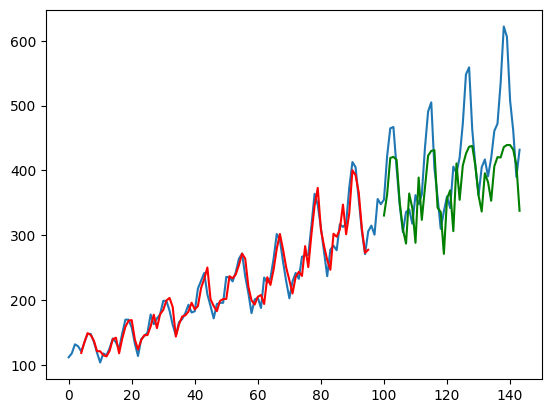

In [ ]:
df = pd.read_csv("airline-passengers.csv")
timeseries = df[["Passengers"]].values.astype("float32")

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]


def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i : i + lookback]
        target = dataset[i + 1 : i + lookback + 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)


class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=50, num_layers=1, batch_first=True
        )
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x


model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(
    data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8
)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size + lookback : len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c="r")
plt.plot(test_plot, c="g")
plt.show()